In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import re
import copy

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def openData():
    """
    Opens the csv with the data and cleans the dataset and returns a dataframe.
    """
    # Sort data in descending order by page visibility. This ensures duplicates without page followers are dropped.
#     data = pd.read_csv("../data/facebook_data_cleaned.csv").sort_values('visibility', ascending=False)
#     data = data.drop_duplicates(['altmetric_id'], keep='first')

    data = pd.read_csv("../data/small_data.csv")
    
    data['fb_wall_urls'] = data['fb_wall_urls'].apply(lambda x: eval(x))
    
    def func(inp):
        if inp is nan:
            return inp
        try:
            res = eval(inp)
        except:
            res = [inp]
        return res
    
    data['subjects'] = data['subjects'].map(func)
    data['scopus_subjects'] = data['scopus_subjects'].map(func)
    data['publisher_subjects'] = data['publisher_subjects'].map(func)
    
    data['fb_wall_count'] = data['fb_wall_count'].astype(int)
    
    return data


In [4]:
data = openData()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 19 columns):
altmetric_id          9334 non-null float64
title                 9273 non-null object
subjects              4995 non-null object
abstract              6041 non-null object
pubdate               9334 non-null object
fb_wall_count         9334 non-null int32
scopus_subjects       5824 non-null object
publisher_subjects    5659 non-null object
fb_wall_urls          9334 non-null object
shares                9334 non-null int64
visibility            9334 non-null int64
total_like            9334 non-null int64
total_love            9334 non-null int64
total_wow             9334 non-null int64
total_haha            9334 non-null int64
total_sad             9334 non-null int64
total_angry           9334 non-null int64
total_reactions       9334 non-null int64
all_subjects          9334 non-null object
dtypes: float64(1), int32(1), int64(9), object(8)
memory usage: 1.3+ MB


In [194]:
df = copy.deepcopy(data)

In [195]:
for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    df[feat] = np.log(df[feat] + 1)
    if feat=='total_like':
        df[feat] = df[feat].apply(lambda x: x**(1/3))
    df[feat][np.isneginf(df[feat])]=0
        

C:\Users\colefreeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [196]:
df.head()

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,visibility,total_like,total_love,total_wow,total_haha,total_sad,total_angry,total_reactions,all_subjects
0,24868043.0,Engaging for a Good Cause: Sophia's Story and ...,NaN,NaN,2017-09-01T00:00:00+00:00,53,"[Agricultural and Biological Sciences, Life Sc...",[Zoology],[{'link': 'https://www.facebook.com/permalink....,6234,0,2.140834,8.704005,6.113682,2.397895,2.484907,1.945910,6504,"['Agricultural and Biological Sciences', 'Life..."
1,21773302.0,White Houseâ€™s dwindling science office leave...,[science],NaN,2017-07-13T00:00:00+00:00,7,[General],NaN,[{'link': 'https://www.facebook.com/permalink....,2709,3315980,2.048731,3.663562,5.303305,2.995732,7.774436,8.119696,5994,"['science', 'General']"
2,21803239.0,TFH-derived dopamine accelerates productive sy...,[science],Protective high-affinity antibody responses de...,2017-07-12T00:00:00+00:00,413,[General],[Immunology],[{'link': 'https://www.facebook.com/permalink....,38272,-362,2.183876,7.843064,8.115820,3.806662,1.945910,1.791759,5948,"['science', 'General', 'Immunology']"
3,24452744.0,â€˜Gluten-free water' shows absurdity of trend...,NaN,Companies are exploiting a knowledge gap with ...,2017-08-29T00:00:00+00:00,59,NaN,NaN,[{'link': 'https://www.facebook.com/permalink....,2928,3262343,2.039749,4.406719,5.267858,8.333991,4.624973,5.669881,4826,[]
4,20490907.0,Galloping Heart,[medicine],NaN,2017-05-25T00:00:00+00:00,73,"[Medicine, Health Sciences]",[Medical And Health Sciences],[{'link': 'https://www.facebook.com/permalink....,5665,4622460,2.141639,6.825460,7.963808,3.367296,1.791759,0.000000,3827,"['medicine', 'Medicine', 'Health Sciences', 'M..."


In [197]:
df['total_reacts'] = df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

In [198]:
df['tot_pos'] = (df['total_love'] + (df['total_wow'] * df['total_love'] /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']

df['tot_neg'] = (df['total_angry'] + df['total_sad'] + (df['total_wow'] * (df['total_angry'] + df['total_sad']) /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']


# df['tot_pos'] = (df['total_love'] + (df['total_wow'] * df['total_love'] /
#                                      (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like'])) + 
                 
#                                      (df['total_like'] * df['total_love'] /
#                                      (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_neg'] = (df['total_angry'] + df['total_sad'] + (df['total_wow'] * (df['total_angry'] + df['total_sad']) /
#                                                         (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like'])) +
                 
#                                                         (df['total_like'] * (df['total_angry'] + df['total_sad']) /
#                                                         (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_pos'] = df['total_love'] / (df['total_love'] + df['total_sad'] + df['total_angry'])

# df['tot_neg'] = (df['total_angry'] + df['total_sad']) / (df['total_love'] + df['total_sad'] + df['total_angry'])

In [199]:
df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']
# df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']

In [200]:
# def f(x):
#     if x > 0:
#         return 1
#     elif x == 0:
#         return 0
#     return -1

df['valence'] = df['tot_pos'] - df['tot_neg']
df['valence'] = df['valence'].apply(lambda x: 1 if x >= 0 else -1)

In [201]:
df['controversy'] = 1 - 4 * abs(np.pi/4 - np.arctan(df['tot_neg']/df['tot_pos'])) / np.pi

C:\Users\colefreeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arctan
  """Entry point for launching an IPython kernel.


In [182]:
# df = df.drop(labels=['subjects', 'abstract', 'pubdate', 'scopus_subjects', 'publisher_subjects'], axis=1)

In [209]:
df.sort_values("controversy", ascending=False).head(1000)

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,...,total_sad,total_angry,total_reactions,all_subjects,total_reacts,tot_pos,tot_neg,intensity,valence,controversy
4853,20042882.0,The doubleâ€�edged experience of healthcare en...,[nursing],to identify and describe the experience of hea...,2017-05-12T13:43:18+00:00,4,"[Health Sciences, Nursing]",[Nursing],[{'link': 'https://www.facebook.com/permalink....,5,...,0.693147,0.000000,2,"['nursing', 'Health Sciences', 'Nursing', 'Nur...",2.916571,0.237658,0.237658,0.475317,1,1.000000
2403,17187090.0,Association of the Timing of Pregnancy With Su...,NaN,Increasing numbers of women experience pregnan...,2017-03-09T00:00:00+00:00,17,NaN,NaN,[{'link': 'https://www.facebook.com/permalink....,120,...,0.693147,0.000000,7,[],4.927750,0.322465,0.322465,0.644930,1,1.000000
4831,26296088.0,Living and dying with advanced dementia: A pro...,[healthservices],Increasing number of people are dying with adv...,2017-08-01T00:00:00+00:00,7,"[Medicine, Health Sciences]",[Public Health And Health Services],[{'link': 'https://www.facebook.com/permalink....,21,...,0.693147,0.000000,2,"['healthservices', 'Medicine', 'Health Science...",2.950696,0.234910,0.234910,0.469819,1,1.000000
1022,16126323.0,rare case pharyngeal perforation expectoration...,[neurosurgery],anterior cervical discectomy fusion acdf commo...,2017-02-06T22:15:18+00:00,2,[Health Sciences],[Clinical Sciences],[{'link': 'https://www.facebook.com/permalink....,0,...,0.000000,0.693147,22,"['neurosurgery', 'Health Sciences', 'Clinical ...",6.048601,0.366268,0.366268,0.732536,1,1.000000
3164,27695489.0,Reversing the tide â€” diagnosis and preventio...,[endocrinology],Populations of African descent are at the fore...,2017-10-23T00:00:00+00:00,3,"[Biochemistry, Genetics and Molecular Biology,...",NaN,[{'link': 'https://www.facebook.com/permalink....,21,...,0.693147,0.000000,4,"['endocrinology', 'Biochemistry, Genetics and ...",4.102691,0.302839,0.302839,0.605677,1,1.000000
1993,16987534.0,Carbon dioxide in carbonated beverages induces...,NaN,The dangerous health risks associated with obe...,2017-02-01T00:00:00+00:00,14,"[Medicine, Health Sciences, Nursing]",[Medical And Health Sciences],[{'link': 'https://www.facebook.com/permalink....,75,...,0.693147,0.000000,9,"['Medicine', 'Health Sciences', 'Nursing', 'Me...",5.923450,0.268260,0.268260,0.721989,1,1.000000
4242,16200939.0,Is 3D printing safe? Analysis of the thermal t...,"[environmentalhealth, occupationalmedicine]",The fast development of low-cost desktop three...,2017-02-07T22:01:57+00:00,5,"[Medicine, Health Sciences]",[Public Health And Health Services],[{'link': 'https://www.facebook.com/permalink....,10,...,0.693147,0.000000,3,"['environmentalhealth', 'occupationalmedicine'...",3.624571,0.286853,0.286853,0.573707,1,1.000000
5692,21206267.0,Grenfell Tower fire exposes the injustice of d...,NaN,"Marginal people become resourceless, invisible...",2017-06-20T00:00:00+00:00,4,NaN,NaN,[{'link': 'https://www.facebook.com/permalink....,2,...,0.693147,0.000000,2,[],2.819585,0.245833,0.245833,0.491666,1,1.000000
3155,28214530.0,Lineage and Legitimacy: Exploring Royal-Famili...,NaN,NaN,2017-10-12T00:00:00+00:00,1,NaN,NaN,[{'link': 'https://www.facebook.com/permalink....,5,...,1.098612,0.000000,4,[],3.602070,0.304995,0.304995,0.609989,1,1.000000
5696,19658004.0,Artificial light at night alters trophic inter...,[environmentalhealth],Despite being globally widespread in coastal r...,2017-04-27T00:00:00+00:00,3,"[Agricultural and Biological Sciences, Life Sc...",[Environmental Sciences],[{'link': 'https://www.facebook.com/permalink....,13,...,0.693147,0.000000,2,"['environmentalhealth', 'Agricultural and Biol...",2.819585,0.245833,0.245833,0.491666,1,1.000000


In [207]:
df.loc[2403]['fb_wall_urls']

[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1025607670904467&id=458120690986504',
  'like': 19,
  'love': 0,
  'wow': 0,
  'haha': 0,
  'sad': 0,
  'angry': 0,
  'page_likes': 1878,
  'page_followers': 1915,
  'message': '妊娠期乳がん症例の予後は妊娠なし乳がん症例と差はない。乳がん診断より6ヶ月〜5年の間に妊娠した乳がん症例の予後は妊娠なし乳がん症例より良好である (文献2017-049)。\n\n"Association of the Timing of Pregnancy With Survival in Women With Breast Cancer."\nhttp://jamanetwork.com/journals/jamaoncology/fullarticle/2608281\n\nカナダ、オンタリオ州のがん登録を用いて、診断時20歳から45歳までの浸潤性乳がん患者7,553例を対象に妊娠と予後の関係を検討した population-based retrospective cohort study。対象を乳がん診断前後5年間妊娠なし (妊娠なし乳がん群)、乳がん診断5年前から1年前までに妊娠あり (診断前妊娠乳がん群)、乳がん診断11ヶ月前から診断21ヶ月後までに妊娠あり (妊娠期乳がん群)、乳がん診断後22ヶ月から5年まで妊娠あり (診断後妊娠乳がん群) に分類した。主観察項目は5年 overall survival、妊娠なし乳がんと比較した年齢補正ハザード比および多変量補正ハザード比、妊娠なし乳がんと比較した年齢補正妊娠時期依存性ハザード比および多変量補正妊娠時期依存性ハザード比。多変量解析では診断年 / 年齢 / 腫瘍径 / リンパ節転移状況 / エストロゲン・レセプター発現状況 / プロゲステロン･レセプター発現状況 / HER2状況 / 化学療法の有無 / 放射線治療の有無について補正を行った。\n●対象の平均年齢は39.1歳、年齢中央値は40歳。平均観察期間は5.2年 (range 0〜

In [169]:
data.loc[5043]

altmetric_id                                                1.55475e+07
title                 cartilage bone transformation fracture healing...
subjects                                          [biology, embryology]
abstract              fractures heal predominantly process endochond...
pubdate                                       2017-01-15T00:00:00+00:00
fb_wall_count                                                         4
scopus_subjects                                       [Social Sciences]
publisher_subjects                                [Biological Sciences]
fb_wall_urls          [{'link': 'https://www.facebook.com/permalink....
shares                                                                9
visibility                                                            0
total_like                                                           16
total_love                                                            1
total_wow                                                       

In [204]:
df.sample(n=1, replace=True)

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,...,total_sad,total_angry,total_reactions,all_subjects,total_reacts,tot_pos,tot_neg,intensity,valence,controversy
5350,21537729.0,The oral bacterial microbiome of occlusal surf...,"[medicine, science]",Dental caries is the most prevalent disease in...,2017-07-05T00:00:00+00:00,2,"[Biochemistry, Genetics and Molecular Biology,...",[Multidisciplinary],[{'link': 'https://www.facebook.com/permalink....,1,...,0.0,0.0,2,"['medicine', 'science', 'Biochemistry, Genetic...",2.437087,NaN,NaN,0.450789,-1,NaN


In [96]:
np.mean(df['intensity'])# * df['valence'])

0.31967810589709506

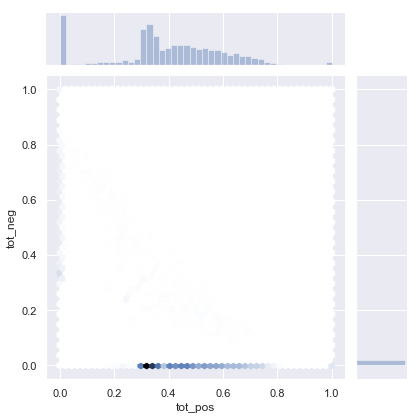

In [170]:
sns.set()

sns.jointplot(x='tot_pos', y='tot_neg', data=df, kind='hex')

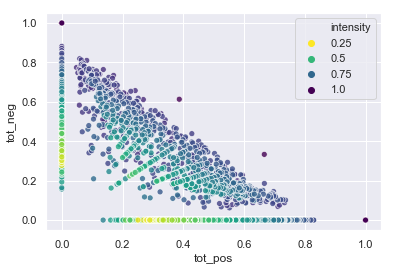

In [172]:
sns.scatterplot(x='tot_pos', y='tot_neg', hue='intensity', data=df, alpha=0.8, palette='viridis_r')

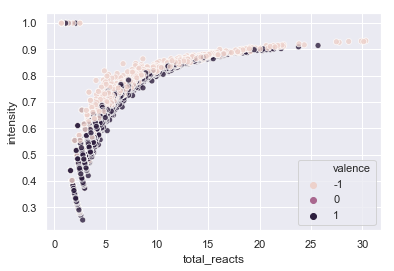

In [216]:
sns.scatterplot(x='total_reacts', y='intensity', hue='valence', data=df, alpha=0.8)

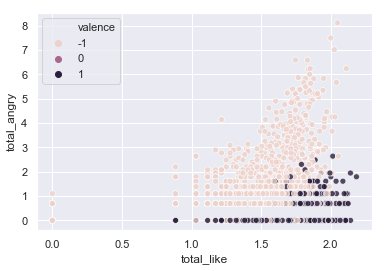

In [222]:
sns.scatterplot(x='total_like', y='total_angry', hue='valence', data=df, alpha=0.8)